In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import tensorflow as tf
import keras
from tensorflow.python.framework import ops
#from cnn_utils import *
import os
import deepdish.io as io
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

%matplotlib inline
np.random.seed(1)

/home/debo/env2/local/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/home/debo/env2/local/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/home/debo/env2/local/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h5r, h5t, h5l, h5p
/home/debo/env2/local/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/debo/env2/local/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: Runtim

In [2]:
print(keras.__version__)
print(np.__version__)

2.0.3
1.15.0


In the original code:

Variable names:
datasetA = io.load(os.path.join(data_prefix, 'MEM-A-0438_ordered' + extra_kw + '.h5'))
datasetB = io.load(os.path.join(data_prefix, 'MEM-B-0438_ordered' + extra_kw + '.h5'))
datasetC = io.load(os.path.join(data_prefix, 'MEM-C-0438_ordered' + extra_kw + '.h5'))
    
train_dataset = datasetA
train_set_x_orig = X_train = datasetA['X'] 
train_set_y_orig = target_train = np.array([datasetA['signal_llh']]).T

test_dataset = datasetB
test_set_x_orig = X_test = datasetB['X'] 
test_set_y_orig = target_test = np.array([datasetB['signal_llh']]).T

eval_dataset = datasetC
eval_set_x_orig = X_eval = datasetC['X'] = scaler_X.transform(X_train)
eval_set_y_orig = target_eval = np.array([datasetC['signal_llh']]).T

- prepare_data()
    - loads the datasets A, B, and C that are already ordered and separated.
    - datasetA, datasetB and datasetC are mapped onto train, test and eval.
    - Their X columns transposed are the signal and their signal_llh columns transposed are the target.
    - The datasets are scaled and the scaler_X and scaler_y are saved in order to apply its inverse after training.


In [7]:
    #data_prefix = '/data/solved/MEMDK/april18/dark-mem/data/1d'
    #data_prefix = '../'
    X = io.load(os.path.join('Samples_X-0438_ordered.h5'))
    print np.shape(X)
    #target = only the signal log likelihood for these runs
    target = io.load(os.path.join('Samples_target-0438_ordered.h5'))
    print np.shape(target)
    y = io.load(os.path.join('Samples_y-0438_ordered.h5'))
    print np.shape(y)
    
       
    X = np.reshape(X, (((np.shape(X))[0])*((np.shape(X))[1]),-1))
    print np.shape(X)
    target = np.reshape(target, (((np.shape(target))[0])*((np.shape(target))[1]),-1))
    print np.shape(target)
    y = np.reshape(y, (((np.shape(y))[0])*((np.shape(y))[1]),-1))
    print np.shape(y)
    
    X_trial = X[0:2000, :]
    target_trial = target[0:2000, :]
    y_trial = y[0:2000, :]
    
    X_test = X[2000:3000, :]
    target_test = target[2000:3000, :]
    y_test = y[2000:3000, :]
    
    print np.shape(X_trial)
    print np.shape(y_trial)
    print np.shape(X_test)
    print np.shape(y_test)
    print np.shape(y_test)
    

(3, 1000, 32)
(3, 1000)
(3, 1000)
(3000, 32)
(3000, 1)
(3000, 1)
(2000, 32)
(2000, 1)
(1000, 32)
(1000, 1)
(1000, 1)


In [4]:
#needed when the model has been saved or pickled and needs to be reloaded
#def process_model(filename, datasets, epoch, filebase="epoch"):
#    net = load_model(filename)    
#
#    out=[]
#    for ds in datasets:
#        X,Y,T=ds
#        Y1=net.predict(X, verbose=2)#
#
#        out.append(Y1)
#
#    return out

#for i,ds in enumerate(datasets):
#        X=ds[0]
#        target=ds[1]
#        truth=ds[2]
#        predict=out[i]

 #       sti=sig_true_i=np.where(truth==1)[0]
 #bti=bkg_true_i=np.where(truth==0)[0]


In [27]:
def sequential_model():
    model = Sequential()
    model.add(Dense(32, input_dim=32, kernel_initializer='normal', activation='sigmoid'))
    #model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
def resnet_model(input_dim, output_dim, target):

    def _build_residual_block(x, apply_first=lambda x: x, apply_last=lambda x: x):

        #indim = x.get_shape()[-1].value
        indim = 40
        skip = apply_first(x)

        h = Dense(60)(x)
        h = Dropout(0.5)(LeakyReLU()(h))

        h = Dense(50)(x)
        h = Dropout(0.5)(LeakyReLU()(h))

        h = Dense(indim)(h)
        h = Dropout(0.5)(LeakyReLU()(h))

        h = apply_last(h)

        h = Dense(indim)(h)

        return LeakyReLU()(merge([h, skip]))

    x = Input(shape=(input_dim, ))

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)

    h = Dense(40)(x)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = _build_residual_block(h)
    #h = _build_residual_block(h, apply_last=_build_residual_block)

    h = Dense(output_dim)(h)
    #y = Activation('sigmoid')(h)
    if target == 'llhs':
        y = h
    else:
        y = Activation('sigmoid')(h) # soft and hard target are constrained between 0 and 1

    return Model(x, y)



In [8]:
def MOHW_model(input_dim, output_dim, target):
    net = Sequential()
    net.add(MaxoutDense(96, 10, input_shape=(input_dim, ), W_regularizer=l1(0.001)))
    net.add(Dropout(0.))

    n_highways = 10
    for _ in xrange(n_highways):
        net.add(Highway(activation = 'relu', transform_bias=-5, W_regularizer=l1l2(0.0005, 0.0005)))
        net.add(Dropout(0.))

    net.add(Dense(64, activation = 'relu'))
    net.add(Dropout(0.))
    net.add(Dense(32, activation = 'relu'))
    net.add(Dropout(0.))
    basis_dim = 20
    if target == 'llhs':
        # initial_basis = np.array([
        #     np.linspace(-110, -50, basis_dim), 
        #     np.linspace(-110, -50, basis_dim)
        # ])
        # net.add(ParametricDense(output_dim, basis_dim=basis_dim, basis_init=initial_basis))
        net.add(Dense(output_dim))
    elif target == 'soft_target':
        # initial_basis = np.array(0, 1, basis_dim)
        # net.add(ParametricDense(output_dim, basis_dim=basis_dim, basis_init=initial_basis))
        net.add(Dense(output_dim))
        net.add(Activation('sigmoid'))
    elif target == 'hard_target':
        net.add(Dense(output_dim))
        net.add(Activation('sigmoid'))
    return net




In [9]:
def HW_model(input_dim, output_dim, target):
    net = Sequential()
    net.add(Dense(96, input_shape=(input_dim, ), W_regularizer=l1(0.001)))
    net.add(Dropout(0.))

    n_highways = 10
    for _ in xrange(n_highways):
        net.add(Highway(activation = 'relu', transform_bias=-5, W_regularizer=l1l2(0.0005, 0.0005)))
        net.add(Dropout(0.))

    net.add(Dense(64, activation = 'relu'))
    net.add(Dropout(0.))
    net.add(Dense(32, activation = 'relu'))
    net.add(Dropout(0.))
    basis_dim = 20
    if target == 'llhs':
        initial_basis = np.array([
            np.linspace(-110, -50, basis_dim),
            np.linspace(-110, -50, basis_dim)
        ])
        net.add(ParametricDense(output_dim, basis_dim=basis_dim, basis_init=initial_basis))
    elif target == 'soft_target':
        initial_basis = np.array(0, 1, basis_dim)
        net.add(ParametricDense(output_dim, basis_dim=basis_dim, basis_init=initial_basis))
        net.add(Activation('sigmoid'))
    elif target == 'hard_target':
        net.add(Dense(output_dim))
        net.add(Activation('sigmoid'))
    return net
    



In [9]:
def dense_model(input_dim, output_dim, target):
    model = Dense()
    n_layers = 15
    for _ in xrange(n_layers):
        h = model.add(Dense(1000, input_dim=input_dim, activation = 'relu'))
        h = model.add(Dense)
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def dense_model(input_dim, output_dim, target):
    x = Input(shape=(input_dim, ))
    n_layers = 15
    for _ in xrange(n_layers):
        h = Dense(1000, activation = 'relu')(x)
        h = Dropout(0.)(h)
    h = Dense(output_dim)(h)
    #y = Activation('sigmoid')(h)
    if target == 'llhs':
        y = h
    else:
        y = Activation('sigmoid')(h) 
    return Model(x, y)

In [16]:
#param_grid = {
#    'clf__optimizer':['rmsprop','adam','adagrad'],
#    'clf__epochs':[4,8],
#    'clf__dropout':[0.1,0.2],
#    'clf__kernel_initializer':['glorot_uniform','normal','uniform']#
#}


In [30]:
seed = 1
np.random.seed(seed)
estimators1 = []
estimators2 = []
MinMaxScaler1 = MinMaxScaler(feature_range=(0, 1), copy=True)
MinMaxScaler2 = MinMaxScaler(feature_range=(0.3, 0.7), copy=True)
#sc_X = StandardScaler()
#X_train = sc_X.fit_transform(X)

estimators1.append(('MinMax', MinMaxScaler1))
estimators1.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=60, batch_size=4, verbose=1)))
pipeline1 = Pipeline(estimators1)

estimators2.append(('MinMax', MinMaxScaler2))
estimators2.append(('mlp', KerasRegressor(build_fn=sequential_model, epochs=60, batch_size=4, verbose=1)))
pipeline2 = Pipeline(estimators2)
#estimator = KerasRegressor(build_fn=sequential_model, epochs=100, batch_size=5, verbose=0)


In [7]:
kfold = KFold(n_splits=3, random_state=seed, shuffle=False)
for train_index, test_index in kfold.split(X):
    print("train shape:", np.shape(train_index), "test shape:", np.shape(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

('train shape:', (2000,), 'test shape:', (1000,))
('train shape:', (2000,), 'test shape:', (1000,))
('train shape:', (2000,), 'test shape:', (1000,))


In [19]:
#pipeline.fit(X_train, y_train)
#predictions = pipeline.predict(X_test)
       

In [31]:
results = cross_val_score(pipeline1, X, target , cv=kfold)
results_y = cross_val_score(pipeline1, X, y , cv=kfold)


print("MinMax: %.2f (%.2f) MSE" % (results.mean(), results.std()))
print("MinMax: %.2f (%.2f) MSE" % (results_y.mean(), results_y.std()))

Epoch 1/60
2000/2000 [==============================] - 0s - loss: 4224.9739 - acc: 0.0000e+00     
Epoch 2/60
2000/2000 [==============================] - 0s - loss: 2331.0938 - acc: 0.0000e+00     
Epoch 3/60
2000/2000 [==============================] - 0s - loss: 1238.5325 - acc: 0.0000e+00     
Epoch 4/60
2000/2000 [==============================] - 0s - loss: 612.5305 - acc: 0.0000e+00     
Epoch 5/60
2000/2000 [==============================] - 0s - loss: 288.3210 - acc: 0.0000e+00     
Epoch 6/60
2000/2000 [==============================] - 0s - loss: 145.0408 - acc: 0.0000e+00     
Epoch 7/60
2000/2000 [==============================] - 0s - loss: 94.7849 - acc: 0.0000e+00     
Epoch 8/60
2000/2000 [==============================] - 0s - loss: 81.7747 - acc: 0.0000e+00     
Epoch 9/60
2000/2000 [==============================] - 0s - loss: 79.5202 - acc: 0.0000e+00     
Epoch 10/60
2000/2000 [==============================] - 0s - loss: 79.3700 - acc: 0.0000e+00     
Epoch 11/6

2000/2000 [==============================] - 0s - loss: 61.9383 - acc: 0.0000e+00     
Epoch 46/60
2000/2000 [==============================] - 0s - loss: 61.7930 - acc: 0.0000e+00     
Epoch 47/60
2000/2000 [==============================] - 0s - loss: 61.5342 - acc: 0.0000e+00     
Epoch 48/60
2000/2000 [==============================] - 0s - loss: 61.2669 - acc: 0.0000e+00     
Epoch 49/60
2000/2000 [==============================] - 0s - loss: 61.0207 - acc: 0.0000e+00     
Epoch 50/60
2000/2000 [==============================] - 0s - loss: 60.7394 - acc: 0.0000e+00     
Epoch 51/60
2000/2000 [==============================] - 0s - loss: 60.5324 - acc: 0.0000e+00     
Epoch 52/60
2000/2000 [==============================] - 0s - loss: 60.2122 - acc: 0.0000e+00     
Epoch 53/60
2000/2000 [==============================] - 0s - loss: 59.8886 - acc: 0.0000e+00     
Epoch 54/60
2000/2000 [==============================] - 0s - loss: 59.7197 - acc: 0.0000e+00     
Epoch 55/60
2000/2000 

KeyboardInterrupt: 

In [8]:
prediction1 = cross_val_predict(pipeline1, X, target, cv=kfold)

In [9]:
print prediction1

[-69.95696  -66.78474  -78.10292  ... -70.88156  -78.768105 -71.339554]


In [24]:

#X = X
#target = target
#truth = y 

#sti = sig_true_i = np.where(truth==1)[0]
#bti = bkg_true_i = np.where(truth==0)[0]

#print np.shape(sti)
#print np.shape(bti)

In [25]:
##        predict=out[i]
#    out=[]
#        Y1=net.predict(X, verbose=2)#
#        out.append(Y1)

#out = []
#predict = 


In [16]:
#target_train = np.array([dataset['bkg_llh'], dataset['signal_llh']]).T
#truth_train = dataset['y'].reshape(-1, 1)
#datasets.append([X_train, target_train, truth_train])
# for i,ds in enumerate(datasets)
#target=ds[1]
#truth=ds[2]
#sti=sig_true_i=np.where(truth==1)[0]
#bti=bkg_true_i=np.where(truth==0)[0]

target = target
truth = y
sti=sig_true_i=np.where(truth==1)[0]
bti=bkg_true_i=np.where(truth==0)[0]

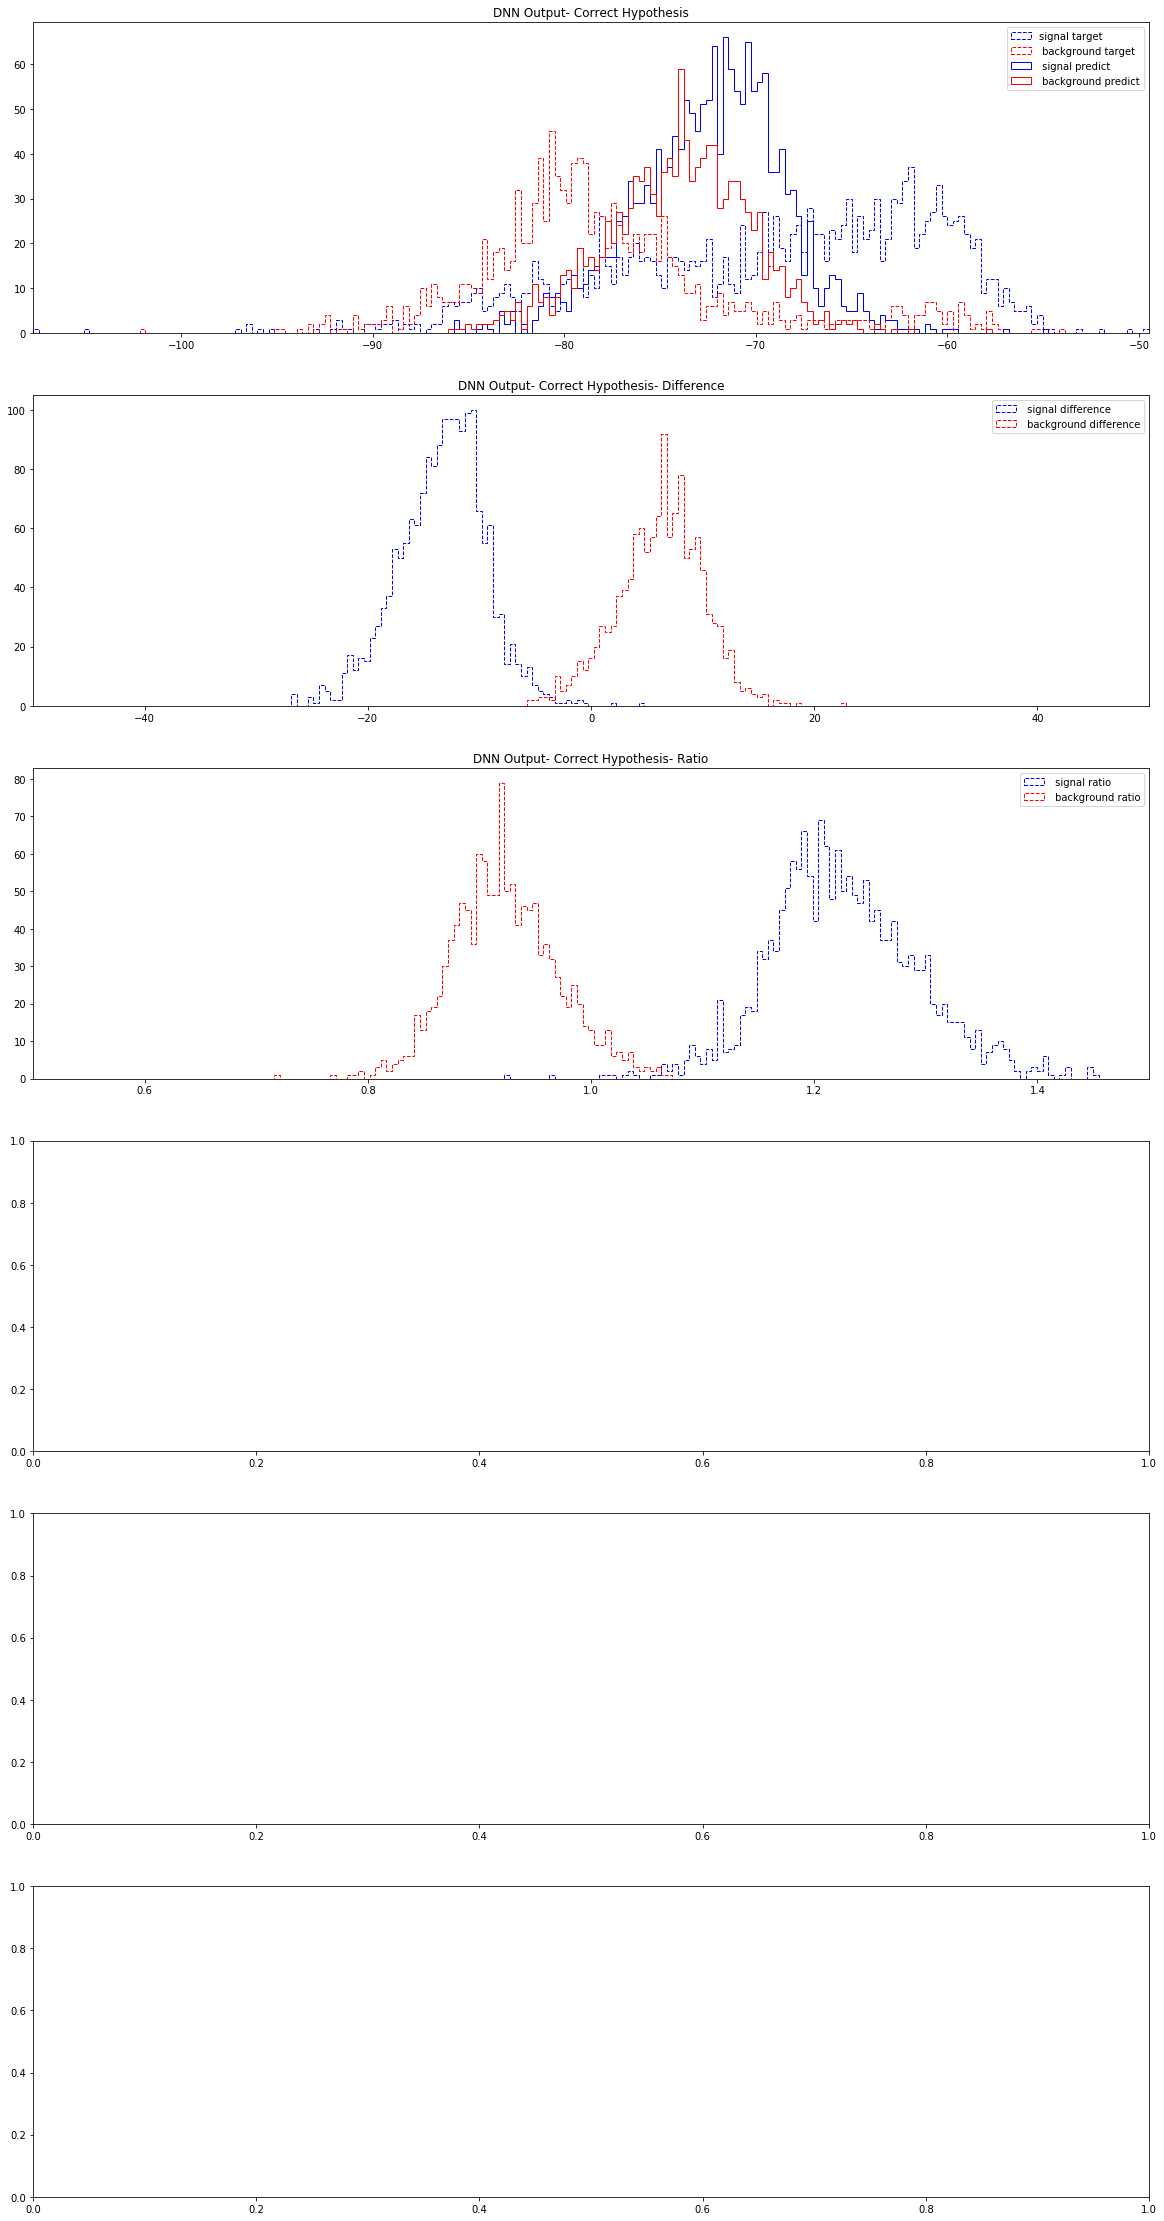

In [17]:
predict = prediction1

# Compare target to predict DNN output
        # Correct Hypo
n_datasets = 1
n_plots = 6
n_bins = 200
f, axarr = plt.subplots(n_plots, n_datasets, sharex=False,
                            #gridspec_kw = {'height_ratios': [1,1,1,1]},
                            figsize=(20, 40),
                            squeeze=False)
plot_i=0
plot_title="DNN Output- Correct Hypothesis"

min_out=min(target.min(),predict.min())
max_out=max(target.max(),predict.max())
bins_out = np.linspace(min_out,max_out,n_bins)
axarr[plot_i,0].set_xlim((min_out,max_out))
        
axarr[plot_i,0].hist(target[sti], color='blue', histtype='step', bins=bins_out, linestyle='dashed', label='signal target')

axarr[plot_i,0].hist(target[bti], color='red', histtype='step', bins=bins_out, linestyle='dashed', label=' background target')
axarr[plot_i,0].hist(predict[sti], color='blue', histtype='step', bins=bins_out, linestyle='solid', label=' signal predict') 
axarr[plot_i,0].hist(predict[bti], color='red', histtype='step', bins=bins_out, linestyle='solid', label=' background predict')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)



# Plot the Difference 
i=1
plot_i=0
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Difference"

diff_sig=predict[sti]-target[sti]
diff_bkg=predict[bti]-target[bti]
#print diff_sig
#print diff_bkg

min_diff=-50
max_diff=50
bins_diff = np.linspace(min_diff,max_diff,n_bins)

axarr[plot_i,0].set_xlim((min_diff,max_diff))
        
axarr[plot_i,0].hist(diff_sig[0], color='blue', histtype='step', bins=bins_diff, linestyle='dashed', label=' signal difference')
axarr[plot_i,0].hist(diff_bkg[0], color='red', histtype='step',bins=bins_diff, linestyle='dashed', label=' background difference')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)


# Plot the Ratio
plot_i+=1
plot_title="DNN Output- Correct Hypothesis- Ratio"

ratio_sig=predict[sti]/target[sti]
ratio_bkg=predict[bti]/target[bti]

min_ratio=0.5
max_ratio=1.5

bins_ratio = np.linspace(min_ratio,max_ratio,n_bins)

axarr[plot_i,0].set_xlim((min_ratio,max_ratio))
        
axarr[plot_i,0].hist(ratio_sig[0], color='blue', histtype='step', bins=bins_ratio, linestyle='dashed', label=' signal ratio')
axarr[plot_i,0].hist(ratio_bkg[0], color='red', histtype='step',bins=bins_ratio, linestyle='dashed', label=' background ratio')
        
axarr[plot_i][0].set_title(plot_title)
axarr[plot_i][0].legend(loc='best', ncol=1)

 

Results from different configurations - test sample:

2 folds shallower (32) MinMax: 77.11 (2.19) MSE
2 folds shallower minmax activ sig MinMax: 64.50 (1.60) MSE
    3 shallower= 62.23 (2.19) MSE
    
    3 deeper (13) MinMax: 68.32 (2.73) MSE
3 deeper sigmoid MinMax: 78.68 (1.89) MSE

3 deeper, wider (32,13,1) sig MinMax: 66.56 (1.09) MSE
relu MinMax: 65.71 (2.18) MSE

MinMax: 65.84 (1.57) MSE 64,1


model.add(Dense(32, input_dim=32, kernel_initializer='normal', activation='sigmoid'))MinMax: 62.19 (1.47) MSE

model.add(Dense(32, input_dim=32, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(12, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(6, kernel_initializer='normal', activation='sigmoid'))

    model.add(Dense(1,MinMax: 78.67 (1.89) MSE

5 folds: MinMax: 60.72 (3.46) MSE
10: MinMax: 59.00 (4.44) MSE

Transpose: MinMax: 78.73 (1.65) MSE
no transpose:MinMax: 62.19 (1.47) MSE



In [7]:
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_trial)
X_test1 = sc_X.fit_transform(X_test)
#sc_Y = StandardScaler()
#y_train1 = sc_Y.fit_transform(y_trial)

#sc_Target = StandardScaler()
#target_train1 = sc_Y.fit_transform(target_trial)

#estimator1 = KerasRegressor(build_fn=sequential_model, epochs=60, batch_size=4,verbose=1)
#estimator1.fit(X_train1,y_train1)

model = Sequential()
#model.add(Dense(12, input_dim=8, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
# Compile model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
#model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10)

#model.add(Dense(32, input_dim=32, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(40, input_dim=32, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(20, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(12, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#model.fit(X_train1, y_trial, validation_split=0.33, epochs=100, batch_size=16)
model.fit(X_train1, y_trial, epochs=200, batch_size=4)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/200
2000/2000 [==============================] - 1s - loss: 0.7196 - acc: 0.5500     
Epoch 2/200
2000/2000 [==============================] - 0s - loss: 0.6762 - acc: 0.5885     
Epoch 3/200
2000/2000 [==============================] - 0s - loss: 0.6692 - acc: 0.5975     
Epoch 4/200
2000/2000 [==============================] - 0s - loss: 0.6575 - acc: 0.6070     
Epoch 5/200
2000/2000 [==============================] - 0s - loss: 0.6533 - acc: 0.6145     
Epoch 6/200
2000/2000 [==============================] - 0s - loss: 0.6532 - acc: 0.6135     
Epoch 7/200
2000/2000 [==============================] - 0s - loss: 0.6449 - acc: 0.6305     
Epoch 8/200
2000/2000 [==============================] - 0s - loss: 0.6468 - acc: 0.6290     
Epoch 9/200
2000/2000 [==============================] - 0s - loss: 0.6536 - acc: 0.6150     
Epoch 10/200
2000/2000 [==============================] - 0s - loss: 0.6476 - acc

2000/2000 [==============================] - 0s - loss: 0.6115 - acc: 0.6810     
Epoch 85/200
2000/2000 [==============================] - 0s - loss: 0.6085 - acc: 0.6935     
Epoch 86/200
2000/2000 [==============================] - 0s - loss: 0.6104 - acc: 0.6715     
Epoch 87/200
2000/2000 [==============================] - 0s - loss: 0.6110 - acc: 0.6855     
Epoch 88/200
2000/2000 [==============================] - 0s - loss: 0.6096 - acc: 0.6765     
Epoch 89/200
2000/2000 [==============================] - 0s - loss: 0.6163 - acc: 0.6685     
Epoch 90/200
2000/2000 [==============================] - 0s - loss: 0.6147 - acc: 0.6655     
Epoch 91/200
2000/2000 [==============================] - 0s - loss: 0.6104 - acc: 0.6910     
Epoch 92/200
2000/2000 [==============================] - 0s - loss: 0.6067 - acc: 0.6860     
Epoch 93/200
2000/2000 [==============================] - 0s - loss: 0.6193 - acc: 0.6630     
Epoch 94/200
2000/2000 [==============================] - 0s - 

In [8]:
score = model.evaluate(X_test1, y_test,batch_size=4)

 968/1000 [============================>.] - ETA: 0s

In [9]:
print(score)

[0.5005527105331421, 0.764]


In [4]:
sc_X = StandardScaler()
X_train1 = sc_X.fit_transform(X_trial)
X_test1 = sc_X.fit_transform(X_test)
model = Sequential()
model.add(Dense(32, input_dim=32, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(12, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(1, kernel_initializer='glorot_normal', activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

model.fit(X_train1, y_trial, epochs=100, batch_size=5)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/100
2000/2000 [==============================] - 0s - loss: 0.2386 - acc: 0.5960     
Epoch 2/100
2000/2000 [==============================] - 0s - loss: 0.2204 - acc: 0.6535     
Epoch 3/100
2000/2000 [==============================] - 0s - loss: 0.2073 - acc: 0.6845     
Epoch 4/100
2000/2000 [==============================] - 0s - loss: 0.1982 - acc: 0.7045     
Epoch 5/100
2000/2000 [==============================] - 0s - loss: 0.1905 - acc: 0.7095     
Epoch 6/100
2000/2000 [==============================] - 0s - loss: 0.1841 - acc: 0.7350     
Epoch 7/100
2000/2000 [==============================] - 0s - loss: 0.1793 - acc: 0.7410     
Epoch 8/100
2000/2000 [==============================] - 0s - loss: 0.1734 - acc: 0.7480     
Epoch 9/100
2000/2000 [==============================] - 0s - loss: 0.1690 - acc: 0.7605     
Epoch 10/100
2000/2000 [==============================] - 0s - loss: 0.1647 - acc

2000/2000 [==============================] - 0s - loss: 0.0273 - acc: 0.9790     
Epoch 85/100
2000/2000 [==============================] - 0s - loss: 0.0260 - acc: 0.9810     
Epoch 86/100
2000/2000 [==============================] - 0s - loss: 0.0269 - acc: 0.9770     
Epoch 87/100
2000/2000 [==============================] - 0s - loss: 0.0266 - acc: 0.9780     
Epoch 88/100
2000/2000 [==============================] - 0s - loss: 0.0284 - acc: 0.9770     
Epoch 89/100
2000/2000 [==============================] - 0s - loss: 0.0248 - acc: 0.9810     
Epoch 90/100
2000/2000 [==============================] - 0s - loss: 0.0240 - acc: 0.9815     
Epoch 91/100
2000/2000 [==============================] - 0s - loss: 0.0275 - acc: 0.9765     
Epoch 92/100
2000/2000 [==============================] - 0s - loss: 0.0284 - acc: 0.9745     
Epoch 93/100
2000/2000 [==============================] - 0s - loss: 0.0279 - acc: 0.9765     
Epoch 94/100
2000/2000 [==============================] - 0s - 

In [5]:
score = model.evaluate(X_test1, y_test,batch_size=5)

 980/1000 [============================>.] - ETA: 0s

In [6]:
print(score)

[0.28422534917840014, 0.678000011742115]
